# Airbnb New User Bookings prediction Using Xgboost

In [71]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
from math import sqrt

import itertools
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.models import load_model
from keras.callbacks import *
from keras import regularizers
from keras import backend as K

import h5py

np.random.seed(0)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print (sys.version)
print(sys.executable)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1145440600391443979
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7584166708
locality {
  bus_id: 1
}
incarnation: 17978135553594761573
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
2.7.6 (default, Oct 26 2016, 20:30:19) 
[GCC 4.8.4]
/home/tonyzhang1231/.virtualenvs/airbnbNewUserBookings/bin/python


# Loading data

In [3]:
df_train = pd.read_csv('../input/train_users.csv')
df_test = pd.read_csv('../input/test_users.csv')
labels = df_train['country_destination'].values
df_train = df_train.drop(['country_destination'], axis=1)
id_test = df_test['id']
piv_train = df_train.shape[0]

In [4]:
df_train.head(10)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox


In [5]:
#Creating a DataFrame with train+test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
#Removing id and date_first_booking
df_all = df_all.drop(['id', 'date_first_booking'], axis=1)
#Filling nan
df_all = df_all.fillna(-1)


In [6]:
df_all.head(10)

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,2010-06-28,20090319043255,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
5,2010-01-01,20100101215619,-unknown-,-1.0,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome
6,2010-01-02,20100102012558,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari
7,2010-01-03,20100103191905,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari
8,2010-01-04,20100104004211,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari
9,2010-01-04,20100104023758,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox


# Feature engineering


In [7]:
def normalizeFeatures(df, features):
    for feature in features:
        scaler = MinMaxScaler()
        df[feature] = scaler.fit_transform(df[feature].values.reshape(-1,1))
#     return df

In [8]:
#date_account_created
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all = df_all.drop(['date_account_created'], axis=1)

#timestamp_first_active
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all = df_all.drop(['timestamp_first_active'], axis=1)

#Age
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)

    
# normalize features
normalizeFeatures(df_all, ['dac_year', 'dac_month', 'dac_day', 'tfa_year', 'tfa_month', 'tfa_day', 'age'])

#Splitting train and test
vals = df_all.values
X = vals[:piv_train]
le = LabelEncoder()
y = le.fit_transform(labels)   
X_test = vals[piv_train:]

print X.shape
print y.shape

(213451, 161)
(213451,)


/home/tonyzhang1231/.virtualenvs/airbnbNewUserBookings/local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify= y)
print X_train.shape, y_val.shape

(192105, 161) (21346,)


In [10]:
# convert y_train, y_val to one hot vector 
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print y_train.shape

(192105, 12)


In [11]:
df_all.head()

,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,0.000000,0.00,0.454545,0.900000,0.0,0.181818,0.600000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.386139,0.25,0.363636,0.800000,0.0,0.363636,0.733333,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.564356,0.00,0.727273,0.900000,0.0,0.454545,0.266667,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.425743,0.25,1.000000,0.133333,0.0,0.818182,1.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.415842,0.00,0.727273,0.433333,0.0,1.000000,0.233333,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Neural Network setup and training 

In [12]:
# timeit decorator
import time
def timeit(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

#         print 'func:%r args:[%r, %r] took: %2.4f sec' % \
#           (f.__name__, args, kw, te-ts)

        print 'func:%r  took: %2.4f sec' % \
          (f.__name__, te-ts)
        return result

    return timed

In [13]:
"""Metrics to compute the model performance."""

# https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings#evaluation
# ndcg_k = dcg_k / idcg_k. 
# In this case, the idcg_k = N

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples, n_classes]  (one hot vector)
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
#     assert y_true.ndim == 2, "dim of y_true should be 2"
    n = y_true.shape[0]
    order = np.argsort(y_score)[...,::-1]
    ret = 0.0
    for i in range(n):
        for j in range(k):
            if y_true[i,order[i,j]] == 1:
                ret += 1.0/np.log2(j+2)
                break
    return ret/n



In [153]:
# build a 4-layer nn model
def build_model_base(**params):
    loadmodelFilepath = params['loadmodelFilepath'] or None
    
    if not loadmodelFilepath or not os.path.exists(loadmodelFilepath):
        assert params['input_shape'], "Missing input shape"
        input_shape = params['input_shape']
        dropout    = params['dropout'] or 0.1
        l2_lambda   = params['l2_lambda'] or 1e-6      
        neurons  = params['neurons']

        model = Sequential()

        model.add(Dense(neurons[0], input_shape = input_shape, kernel_initializer="uniform",activation='relu', \
                        kernel_regularizer=regularizers.l2(l2_lambda)))
        model.add(Dropout(dropout))

        model.add(Dense(neurons[1], kernel_initializer="uniform",activation='relu', \
                        kernel_regularizer=regularizers.l2(l2_lambda)))
        model.add(Dropout(dropout))

        model.add(Dense(neurons[2], kernel_initializer="uniform",activation='relu', \
                        kernel_regularizer=regularizers.l2(l2_lambda)))

        model.add(Dropout(dropout))

        model.add(Dense(neurons[3],kernel_initializer="uniform",activation='softmax'))
    
    else:
        try:
            model = load_model(loadmodelFilepath)
        except:
            pass
    
    init_lr = params['init_lr'] or 0.01
    lr_decay = params['lr_decay'] or 1
    loss = params['loss']
    optimizer = params ['optimizer']
    metrics  = params ['metrics']
    
    adam = keras.optimizers.Adam(lr= init_lr, decay=lr_decay)
    model.compile(loss=loss,optimizer=optimizer, metrics = metrics)
    model.summary()
    return model

def adjustDropoutRateCallback(epoch, logs):
#     assert isinstance(model, keras.Sequential), "model must be a keras.Sequential instance"
    for layer in model.layers:
        if isinstance(layer, keras.layers.Dropout):
            layer.rate = epoch*1.0/epochs * 0.8

In [154]:
# callbacks = []
callbacks = [
    ModelCheckpoint(filepath='../model/nnbaseModel.hdf5', \
                    monitor='val_loss', save_best_only=True, verbose=0, mode= 'auto', period=1),
    LambdaCallback(on_epoch_end=adjustDropoutRateCallback),
]

# Parameters : dropout, neurons, epochs, learning rate decay, epochs, seq_len

params = {
    'input_shape': X_train.shape[1:],
    'dropout'    : 0.0,
    'neurons'    : [512, 256, 64, 12],
    'l2_lambda'  : 0.001,
    'lr_decay'   : 3,
    'init_lr'    : 0.0001,
    'metrics'    : ['accuracy'],
    'optimizer'  : 'adam',
    'loss'       : 'categorical_crossentropy',
    'loadmodelFilepath' : None #'../model/nnbaseModel.hdf5'
}

epochs = 300

In [155]:
model = build_model_base(**params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 512)               82944     
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 12)                780       
Total para

In [156]:
history = model.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=epochs,
    callbacks = callbacks,
    validation_data = (X_val, y_val),
    verbose=1)

Train on 192105 samples, validate on 21346 samples
Epoch 1/300
192105/192105 [==============================] - 2s 12us/step - loss: 1.4382 - acc: 0.5726 - val_loss: 1.1695 - val_acc: 0.5835

In [157]:
def plotTrainTestLoss(history):
    assert isinstance(history, keras.callbacks.History), "input must be a keras.callbacks.History instance"
    train_metrics = history.history
    plt.close('all')
    f, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.plot(train_metrics['loss'], color='blue', label='train_loss')
    ax1.legend(loc='best')
    
    ax2.plot(train_metrics['val_loss'], color='red', label='val_loss')
    ax2.legend(loc='best')
    f.subplots_adjust(hspace=0.1)
    plt.xlabel("Epochs")
    plt.show()
    
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train loss: {:05f}, train accuracy: {:05f}'.format(trainScore[0], trainScore[1]))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Val loss:   {:05f}, val accuracy:   {:05f}'.format(testScore[0], testScore[1]))
    return trainScore, testScore


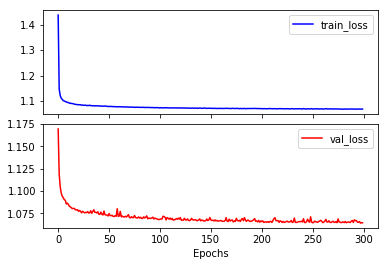

In [158]:
plotTrainTestLoss(history)

In [159]:
thisBestModel = load_model('../model/nnbaseModel.hdf5')
trainScore, testScore = model_score(thisBestModel, X_train, y_train, X_val, y_val)
model_score(model, X_train, y_train, X_val, y_val)

Train loss: 1.061654, train accuracy: 0.637875
Val loss:   1.063873, val accuracy:   0.635107
Train loss: 1.062368, train accuracy: 0.638063
Val loss:   1.064172, val accuracy:   0.634686


([1.0623684056772447, 0.63806251789401525],
 [1.0641723514066734, 0.63468565539211097])

### Save the result

In [174]:
y_pred = thisBestModel.predict_proba(X_test)
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [175]:
#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('../output/nnmodel-result-{}-noOpt.csv'.format(datetime.date.today()),index=False)
# 0.86450

# Tuning parameters

### Save the result

In [47]:
y_pred = thisBestModel.predict_proba(X_test)
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [50]:
#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('../output/nnmodel-result-1126.csv',index=False)

In [27]:
# give us a result of 0.86400


#### reference: https://www.kaggle.com/svpons/script-0-8655